In [99]:
!pip install monai

In [100]:
!pip3 install nibabel

In [101]:
!pip3 install torch

In [102]:
!pip3 install sklearn

In [7]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from sklearn.metrics import classification_report

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
)
from monai.utils import set_determinism

print_config()

MONAI version: 1.4.0
Numpy version: 1.26.4
Pytorch version: 2.5.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: /Users/<username>/.pyenv/versions/3.9.10/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: 1.13.1
Pillow version: 10.4.0
Tensorboard version: 2.16.2
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: NOT INSTALLED or UNKNOWN VERSION.
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.6
pandas version: 2.2.2
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT I

In [104]:
import os
import nibabel as nib
from sklearn.model_selection import train_test_split
#T1 dataset :https://brain-development.org/ixi-dataset/
# Define your NIfTI image directory
image_dir = "/Users/Sepideh/Desktop/bs-implicit/IXI-T1/" 
          
# Load all NIfTI file paths
image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith('.nii.gz')]
print(f"Total NIfTI files found: {len(image_paths)}")

# Split the data into training, validation, and test sets
train_val_paths, test_paths = train_test_split(image_paths, test_size=0.3, random_state=42)  # 70% for train+val, 30% for test
train_paths, val_paths = train_test_split(train_val_paths, test_size=0.2857, random_state=42)  # 20% for validation

print(f"Training size: {len(train_paths)}, Validation size: {len(val_paths)}, Test size: {len(test_paths)}")

# Example: Load one NIfTI file to verify
example_path = train_paths[100]
nifti_image = nib.load(example_path)  # Load NIfTI image
image_data = nifti_image.get_fdata()  # Access image data as a NumPy array

print(f"Loaded NIfTI image shape: {image_data.shape}")


Total NIfTI files found: 581
Training size: 290, Validation size: 116, Test size: 175
Loaded NIfTI image shape: (256, 256, 150)


In [107]:
print(f"Loaded NIfTI image type: {image_data.dtype}")
#

Loaded NIfTI image type: float64


[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


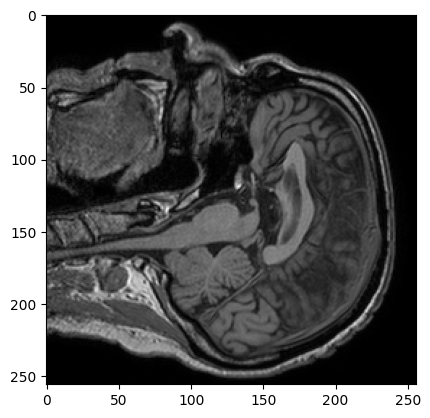

In [109]:
#this will plot full siz size 
Nifti_img =nifti_image.get_fdata()
print(Nifti_img)
plt.imshow(Nifti_img[:,:,Nifti_img.shape[2]//2], cmap='gray')
plt.show()

In [ ]:
from monai import transforms

train_transform = Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.Lambdad(keys="image", func=lambda x: x[3,256, 256, 150]),  # Extract the second channel if applicable
        transforms.EnsureChannelFirstd(keys=["image"], strict_check=True ,channel_dim="no_channel"),
        transforms.ScaleIntensityd(keys=["image"]),
        transforms.CenterSpatialCropd(keys=["image"], roi_size=[176, 224, 155]),
        transforms.Resized(keys=["image"], spatial_size=(32, 48, 32)),
        transforms.CropForegroundd(keys=["Image"],source_key='Image'),
    ]
)
    
val_transform = Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.Lambdad(keys="image", func=lambda x: x[3,:, :, :]),
        transforms.EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),
        transforms.ScaleIntensityd(keys=["image"]),
        transforms.CenterSpatialCropd(keys=["image"], roi_size=[176, 224, 155]),
        transforms.Resized(keys=["image"], spatial_size=(32, 48, 32)),
    ]
)

/Users/Sepideh/.pyenv/versions/3.9.10/lib/python3.9/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


In [113]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        data = {"image": image_path}
        if self.transform:
            data = self.transform(data)
        return data

train_ds = CustomDataset(train_paths, transform=train_transform)
val_ds = CustomDataset(val_paths, transform=val_transform)


In [114]:
print(f"Number of training samples: {len(train_ds)}")
print(f"Number of validation samples: {len(val_ds)}")

Number of training samples: 290
Number of validation samples: 116


In [116]:
import os
import nibabel as nib
from sklearn.model_selection import train_test_split
from monai.transforms import Compose, LoadImaged, Lambdad, EnsureChannelFirstd, ScaleIntensityd, CenterSpatialCropd, Resized
from torch.utils.data import Dataset

# Define your NIfTI image directory
image_dir = "/Users/Sepideh/Desktop/bs-implicit/IXI-T1/" 

# Load all NIfTI file paths
image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith('.nii.gz')]
print(f"Total NIfTI files found: {len(image_paths)}")

# Split the data into training, validation, and test sets
train_val_paths, test_paths = train_test_split(image_paths, test_size=0.3, random_state=42)  # 70% for train+val, 30% for test
train_paths, val_paths = train_test_split(train_val_paths, test_size=0.2857, random_state=42)  # 20% for validation

print(f"Training size: {len(train_paths)}, Validation size: {len(val_paths)}, Test size: {len(test_paths)}")

# Example: Load one NIfTI file to verify
if len(train_paths) > 100:  # Ensure there are at least 101 images
    example_path = train_paths[100]
    nifti_image = nib.load(example_path)  # Load NIfTI image
    image_data = nifti_image.get_fdata()  # Access image data as a NumPy array

    print(f"Loaded NIfTI image shape: {image_data.shape}")

# Define transformations
train_transform = Compose(
    [
        LoadImaged(keys=["image"]),
        Lambdad(keys="image", func=lambda x: x[3, 256, 256, 150] if x.ndim > 3 else x),  # Adjust based on dimensionality
        EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),
        ScaleIntensityd(keys=["image"]),
        CenterSpatialCropd(keys=["image"], roi_size=[176, 224, 155]),
        Resized(keys=["image"], spatial_size=(32, 48, 32)),
        transforms.CropForegroundd(keys=["Image"],source_key='Image'),
    ]
)

val_transform = Compose(
    [
        LoadImaged(keys=["image"]),
        Lambdad(keys="image", func=lambda x: x[3, :, :, :] if x.ndim > 3 else x),
        EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),
        ScaleIntensityd(keys=["image"]),
        CenterSpatialCropd(keys=["image"], roi_size=[176, 224, 155]),
        Resized(keys=["image"], spatial_size=(32, 48, 32)),
    ]
)

# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        data = {"image": image_path}
        if self.transform:
            data = self.transform(data)
        return data

# Create datasets
train_ds = CustomDataset(train_paths, transform=train_transform)
val_ds = CustomDataset(val_paths, transform=val_transform)


Total NIfTI files found: 581
Training size: 290, Validation size: 116, Test size: 175
Loaded NIfTI image shape: (256, 256, 150)


In [41]:

sample = train_ds[0]

# Check if the "image" key exists and print its shape
if "image" in sample:
    print(f"Sample image shape: {sample['image'].shape}")
else:
    print("Transform did not produce 'image' key!")

Sample image shape: torch.Size([1, 32, 48, 32])


In [43]:
batch_size = 16
num_workers = 8


train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)

val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, persistent_workers=True)

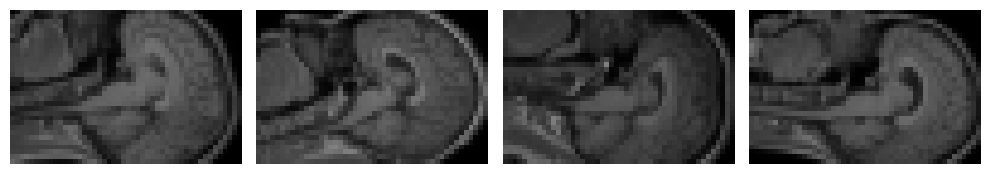

In [46]:
plt.subplots(1, 4, figsize=(10, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(train_ds[i * 20]["image"][0, :, :, 15].detach().cpu(), vmin=0, vmax=1, cmap="gray")
    plt.axis("off")
plt.tight_layout()
plt.show()

function output_range
For values in x less than -rng, replace them with -rng.
For values in x greater than rng, replace them with rng.

In [ ]:
def output_range(x):
    rng = 1
    x = torch.where(x > -rng, x, -rng * torch.ones_like(x))
    x = torch.where(x < rng, x, rng * torch.ones_like(x))
    return x
#input is torch 


In [48]:
x = torch.tensor([-2.0, -0.5, 0.5, 2.0])
output = output_range(x)
print(output) 

tensor([-1.0000, -0.5000,  0.5000,  1.0000])


In [89]:
# PSNR function to evaluate image quality
def psnr(y_true, y_pred):
    # Ensure both tensors are PyTorch tensors, if needed
    if isinstance(y_true, np.ndarray):
        y_true = torch.tensor(y_true)
    if isinstance(y_pred, np.ndarray):
        y_pred = torch.tensor(y_pred)

    # Calculate Mean Squared Error (MSE)
    mse = torch.mean((y_true - y_pred) ** 2)
    PIXEL_MAX = 255.0  # original is 255 but (gt)Normalized image pixel range [0, 1]
    return 20 * torch.log10(PIXEL_MAX / torch.sqrt(mse))

In [90]:
def implicit_relation(tensor):
    a = tensor[0]
    b = tensor[1]
    c = a - b
    return c

In [91]:

# Implicit correction: Apply normalization and ensure the tensor has the correct structure
def implicit_correction(tensor):
    # Ensure that tensor is a PyTorch tensor (if it's a NumPy array)
    if isinstance(tensor, np.ndarray):
        tensor = torch.tensor(tensor)

    c = tensor  # Only one tensor, the result of subtraction
    
    # Compute the minimum along axes (1, 2, 3)
    c_min = torch.min(c, dim=1, keepdim=True).values
    c = c + c_min  # Add the minimum value back to c
    
    # Compute the maximum along axes (1, 2, 3)
    c_max = torch.max(c, dim=1, keepdim=True).values
    c = c / (c_max + 1e-8)  # Adding epsilon for numerical stability
    
    return c

In [92]:
import torch
import torch.nn as nn

# Define a model using 3D convolutions
class Model(nn.Module):
    def __init__(self, dropout_rate=0.2, filt=2, kernel_size=3):
        super(Model, self).__init__()
        
        # Change Conv2d to Conv3d for 3D data (e.g., MRI scans)
        self.conv1 = nn.Conv3d(1, filt, kernel_size, padding=1)
        self.conv2 = nn.Conv3d(filt, filt * 2, kernel_size, padding=1)
        self.conv3 = nn.Conv3d(filt * 2, filt * 4, kernel_size, padding=1)
        self.conv4 = nn.Conv3d(filt * 4, filt * 8, kernel_size, padding=1)
        self.conv5 = nn.Conv3d(filt * 8, filt * 16, kernel_size, padding=1)
        self.conv_final = nn.Conv3d(filt * 16, 1, kernel_size, padding=1)
        
        # Dropout and BatchNorm layers (for regularization)
        self.dropout = nn.Dropout3d(dropout_rate)  # Use 3D dropout
        self.batchnorm = nn.BatchNorm3d(filt * 16)  # BatchNorm for 3D data

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout(x)
        x = self.conv3(x)
        x = self.dropout(x)
        x = self.conv4(x)
        x = self.dropout(x)
        x = self.conv5(x)
        x = self.conv_final(x)
        return x

# Instantiate the model
model = Model()  # Assuming GPU usage


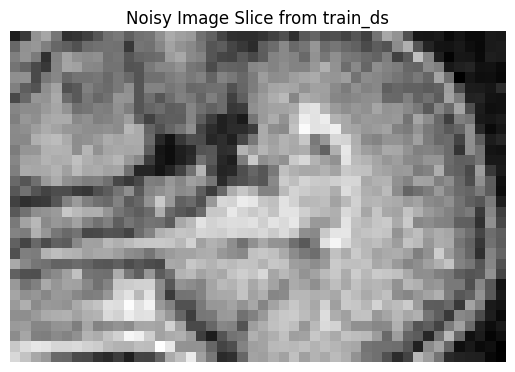

In [93]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Load the first image from the dataset
data = train_ds[0]  # Get the first item (image) from the train dataset

# The 'image' key contains the image tensor after transformations
image_tensor = data['image']

# Convert the image tensor to a NumPy array for visualization
image_numpy = image_tensor.squeeze().cpu().numpy()  # Remove channel and batch dimensions if present

# Add Gaussian noise
noise_size = 0.02
b_tensor = torch.normal(mean=0, std=noise_size, size=image_tensor.shape)  # Create Gaussian noise
v_tensor = image_tensor + b_tensor  # Add noise to the image

# Normalize the noisy image to [0, 1]
v_tensor = (v_tensor - v_tensor.min()) / (v_tensor.max() - v_tensor.min())  # Normalize

# Convert the noisy image tensor to a NumPy array for visualization
v_numpy = v_tensor.squeeze().cpu().numpy()  # Convert to NumPy for visualization

# Select a slice from the 3D image. For example, choose the middle slice along the 3rd dimension (axis=2)
slice_index = v_numpy.shape[2] // 2  # Middle slice
image_slice = v_numpy[:, :, slice_index]  # Extract that slice

# Normalize the image slice for better visualization
image_slice = np.interp(image_slice, (image_slice.min(), image_slice.max()), (0, 1))

# Display the noisy slice using Matplotlib
plt.imshow(image_slice, cmap='gray')
plt.title("Noisy Image Slice from train_ds")
plt.axis('off')  # Hide axis for better visualization
plt.show()





In [ ]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import torch.nn as nn

n_epochs = 10
noise_size = 0.02
n_its = 500  # Number of iterations per epoch
model = Model()  
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.MSELoss()

# Create your DataLoader for the dataset (train_ds) -> it is extra!
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)

for epoch in range(n_epochs):
    epoch_loss = []

    # Training mode
    model.train()

    for idx, data in enumerate(train_loader):
        # Load the first image and add Gaussian noise
        image_tensor = data['image']  # Image tensor from the dataset (assumed to be 4D)
        noise = torch.normal(mean=0, std=noise_size, size=image_tensor.shape)  # Create Gaussian noise
        noisy_image = image_tensor + noise  # Add noise to the image

        # Forward pass: Predict the denoised image
        optimizer.zero_grad()  # Zero gradients
        denoised_image = model(noisy_image)  # Denoising model

        # Compute loss (Mean Squared Error)
        loss = loss_fn(denoised_image, image_tensor)
        epoch_loss.append(loss.item())

        # Backward pass: Compute gradients and update weights
        loss.backward()
        optimizer.step()

        # Implicit training - Apply correction
        b_hat = np.random.normal(0, noise_size, size=noisy_image.shape)
        vb_hat = noisy_image + torch.tensor(b_hat)  # Add noise

        # Implicit correction: Calculate and apply implicit relation and correction
        implicit_tensor = [vb_hat, image_tensor]
        implicit_result = implicit_relation(implicit_tensor)  # Subtract tensors (relate the noisy and clean images)
        corrected_image = implicit_correction(implicit_result)  # Apply implicit correction

        # Optionally, calculate loss for implicit model (based on the implicit output)
        implicit_loss = loss_fn(corrected_image, image_tensor)
        epoch_loss.append(implicit_loss.item())

    # Calculate and print average loss for the epoch
    avg_loss = np.mean(epoch_loss)
    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {avg_loss:.4f}")

    # Evaluate PSNR for denoised images (ensure both are tensors)
    denoised_image = denoised_image.squeeze().detach()  # Ensure tensor
    original_image = image_tensor.squeeze().detach()  # Ensure tensor

    print(f'PSNR: {psnr(original_image, denoised_image):.4f}')

    # Save images for visualization (original, noisy, and denoised)
    filename = f"AWGN_epoch_{epoch+1}.png"
    plt.figure(figsize=(15, 5.5))

    # Original Image
    plt.subplot(1, 3, 1)
    # Extract a middle slice (depth axis)
    slice_index = original_image.shape[0] // 2
    image_slice = original_image[slice_index, :, :].numpy()  # Extract 2D slice for display
    plt.imshow(image_slice, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # Noisy Image
    plt.subplot(1, 3, 2)
    noisy_image_numpy = noisy_image.squeeze().detach().numpy()
    noisy_image_slice = noisy_image_numpy[slice_index, :, :]
    plt.imshow(noisy_image_slice, cmap='gray')
    plt.title(f'Noisy Image (PSNR: {psnr(original_image, noisy_image):.4f})')
    plt.axis('off')

    # Denoised Image
    plt.subplot(1, 3, 3)
    denoised_image_numpy = denoised_image.detach().numpy()
    denoised_image_slice = denoised_image_numpy[slice_index, :, :]
    plt.imshow(denoised_image_slice, cmap='gray')
    plt.title(f'Denoised Image (PSNR: {psnr(original_image, denoised_image):.4f})')
    plt.axis('off')

    # Save the figure
    plt.tight_layout()
    plt.savefig(filename)
    plt.close('all')


Epoch [1/10], Loss: 0.3773
PSNR: 65.2731
Epoch [2/10], Loss: 0.3739
PSNR: 68.1823
Epoch [3/10], Loss: 0.3733
PSNR: 73.2541
Epoch [4/10], Loss: 0.3732
PSNR: 74.7918
Epoch [5/10], Loss: 0.3731
PSNR: 71.1961
Epoch [6/10], Loss: 0.3730
PSNR: 68.8833
Epoch [7/10], Loss: 0.3729
PSNR: 72.6583
Epoch [8/10], Loss: 0.3728
PSNR: 65.4317
Epoch [9/10], Loss: 0.3728
PSNR: 70.0930
Epoch [10/10], Loss: 0.3727
PSNR: 72.5673
